# MEI Demo

In [1]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USERNAME']
dj.config['database.password'] = os.environ['DJ_PASSWORD']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 15

name = 'vei'
os.environ["DJ_SCHEMA_NAME"] = f"metrics_{name}"
dj.config["nnfabrik.schema_name"] = os.environ["DJ_SCHEMA_NAME"]

In [2]:
import os
import wandb
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (3, 3)
import seaborn as sns
import torch
from torch import load
from scipy.stats import beta, gamma, lognorm

from nnfabrik.main import *
from mei.main import MEISeed, MEIMethod
from nnfabrik.main import Dataset, my_nnfabrik
from nnsysident.tables.experiments import TrainedModel, schema
from nnsysident.tables.mei import MEISelector, TrainedEnsembleModel, MEI, MEIMonkey, MEIExperimentsMonkey, MEIExperimentsMouse, Gradients
from nnsysident.utility.measures import get_loss, get_correlations
from nnvision.tables.main import Recording

device = "cuda"
random_seed = 42

Connecting konstantin@134.76.19.44:3306


In [55]:
(TrainedModel & (TrainedEnsembleModel.Member() & "ensemble_hash = '694b7602e4c885daccccc10991dddded'")).proj().fetch(limit=1, as_dict=True)[0]

{'model_fn': 'nnsysident.models.models.stacked2d_zig',
 'model_hash': '49503eacc668e8950bcc3414e1d623d7',
 'dataset_fn': 'nnsysident.datasets.mouse_loaders.static_loaders',
 'dataset_hash': '9a0e27627452efcb94aed97825771e23',
 'trainer_fn': 'nnsysident.training.trainers.standard_trainer',
 'trainer_hash': '69601593d387758e9ff6a5bf26dd6739',
 'seed': 3}

In [58]:
for s in np.arange(16, 56):
    Seed().insert1({"seed": s})

In [59]:
key = {'model_fn': 'nnsysident.models.models.stacked2d_zig',
 'model_hash': '49503eacc668e8950bcc3414e1d623d7',
 'dataset_fn': 'nnsysident.datasets.mouse_loaders.static_loaders',
 'dataset_hash': '9a0e27627452efcb94aed97825771e23',
 'trainer_fn': 'nnsysident.training.trainers.standard_trainer',
 'trainer_hash': '69601593d387758e9ff6a5bf26dd6739'}

In [60]:
TrainedModel.progress(key)

TrainedModel         Completed 15 of 55 (27.3%)   2023-10-13 12:05:44


(40, 55)

___

## Orthogonal VEIs

In [6]:
experiment_name = "Orthogonal VEIs, UNCORRUPTED Jiakun"
table = MEI() & (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'")

# table = table & "unit_id in (1, 97)"

In [8]:
uid = 97 #neuron_ids[-1] #neuron_ids_abs[-1] #neuron_ids[-1]
mei_table = table & "unit_id = {}".format(uid)
dataloader, model = (TrainedModel & (TrainedEnsembleModel.Member & mei_table & "seed = 3")).load_model()
model.to(device)
model.eval();

idx = np.where(dataloader["train"]["27940-2-13-0"].dataset.neurons.unit_ids == uid)[0].item()

/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:125: UserWarning: The default of `independent_bn_bias=True` will ignore the kwargs `bias`, `batch_norm_scale`, and `final_batchnorm_scale` when initializing the batchnorm. If you want to use these arguments, please set `independent_bn_bias=False`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:161: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:14: UserWarning: Ignoring input {} when creating MLP
  warnings.warn("Ignoring input {} wh

In [9]:
vei_min = torch.from_numpy(data.loc[(data["unit_id"] == uid) & (data["vei_type"] == "min")]["mei"].item()).to(device)
vei_max = torch.from_numpy(data.loc[(data["unit_id"] == uid) & (data["vei_type"] == "max")]["mei"].item()).to(device)

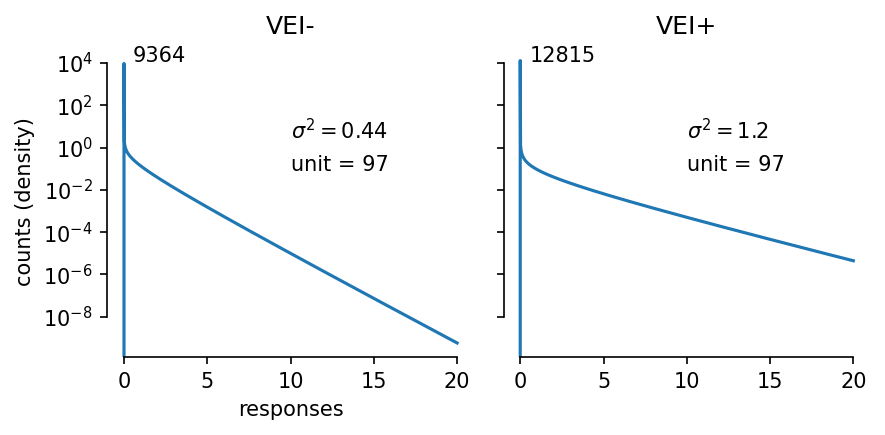

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=150, sharey=True, sharex=True)

for i, (ax, vei, label) in enumerate(zip(axes.flat, [vei_min, vei_max], ["VEI-", "VEI+"])):
    
    behavior = torch.zeros((vei_min.shape[0], 3)).to(device) 
    pupil_center = torch.zeros((vei_min.shape[0], 2)).to(device)
    theta, k, loc, q = model(vei, data_key="27940-2-13-0", behavior=behavior, pupil_center=pupil_center)
    var = np.round(model.predict_variance(vei, 
                                          data_key="27940-2-13-0",
                                          behavior=behavior,
                                          pupil_center=pupil_center)[0, idx].item(), decimals=2)
    
    theta = theta[0, idx].item()
    k = k[0, idx].item()
    loc = loc[0, idx].item()
    q = q[0, idx].item()
    
    x = np.linspace(0, 20, 1000)
    y_gamma = gamma(k, loc=loc, scale=theta).pdf(x[x>=loc]) * q
    y_uniform = np.ones(len(x[x<loc])) * (1-q)/loc
    y = np.hstack([y_uniform, y_gamma])
    
    # ax.fill_between(x[x<loc], y_uniform, lw=.1, color='firebrick', alpha=.6, zorder=1, label='uniform');
    # ax.fill_between(x[x>=loc], y_gamma, lw=.1, color='darkorange', alpha=.6, zorder=1, label='gamma');
    
    ax.plot(np.concatenate([np.array([0]), x]), np.concatenate([np.array([0]), y_uniform, y_gamma]))

    if i==0:
        ax.set(xlabel='responses', ylabel='counts (density)')
        
    # ax.set(xlim = (-2, 30))
    ax.set_title(label)
    ax.text(.5, .7, r"$\sigma^2 = {}$".format(var), transform=ax.transAxes)
    ax.text(.5, .6, r"unit = {}".format(uid), transform=ax.transAxes)
    
    ax.set_yscale("log")
    # ax.set(ylim=[0, 4])
    ax.text(.07, .95, "{}".format(int(y_uniform[0])), transform=ax.transAxes)

sns.despine(trim=True)
fig.tight_layout()

# fig.savefig('figures/' + name + ".png", bbox_inches='tight')

In [10]:
def zig_pdf(theta, k, loc, q, samples):
    y_gamma = gamma(k, loc=loc, scale=theta).pdf(samples[samples>loc]) * q
    y_uniform = np.ones(len(samples[samples<=loc])) * (1-q)/loc
    log_y = np.hstack([y_uniform, y_gamma])
    return log_y

def get_params(vei, model, idx):
    behavior = torch.zeros((vei.shape[0], 3)).to(device) 
    pupil_center = torch.zeros((vei.shape[0], 2)).to(device)
    theta, k, loc, q = model(vei, data_key="27940-2-13-0", behavior=behavior, pupil_center=pupil_center)
    var = np.round(model.predict_variance(vei, 
                                          data_key="27940-2-13-0",
                                          behavior=behavior,
                                          pupil_center=pupil_center)[0, idx].item(), decimals=2)

    theta = theta[0, idx].item()
    k = k[0, idx].item()
    loc = loc[0, idx].item()
    q = q[0, idx].item()
    return theta, k, loc, q

In [39]:
def get_sigma_plus(all_samples_n, seed):
    np.random.seed(seed)

    # Get zig params from max vei
    theta, k, loc, q = get_params(vei_max, model, idx)

    # Sample from this distribution
    samples = gamma(k, loc=loc, scale=theta).rvs(all_samples_n[-1])
    uniform_samples = np.random.rand(all_samples_n[-1]) * loc
    uniform_samples_idx = (np.random.rand(all_samples_n[-1]) >= q)
    samples[uniform_samples_idx] = uniform_samples[uniform_samples_idx]

    all_p_sigma_plus = []
    for samples_n in all_samples_n:

        # Compute probability of the samples...
        # ... for max vei distribution
        theta, k, loc, q = get_params(vei_max, model, idx)
        p_plus = zig_pdf(theta, k, loc, q, samples[:samples_n])
        # ... for min vei distribution
        theta, k, loc, q = get_params(vei_min, model, idx)
        p_minus = zig_pdf(theta, k, loc, q, samples[:samples_n])

        # Compute probability of the samples coming from max vei distribution
        # p_sigma_plus = np.prod(p_plus)/(np.prod(p_plus) + np.prod(p_minus))
        p_sigma_plus = np.log(p_plus).sum() - np.logaddexp(np.log(p_plus).sum(), np.log(p_minus).sum())
        all_p_sigma_plus.append(p_sigma_plus)
    return all_p_sigma_plus

In [40]:
all_samples_n = np.arange(1, 101)

dat = pd.DataFrame(columns=["seed", "sigma", "samples_n"])
for seed in np.arange(20):
    all_p_sigma_plus = get_sigma_plus(all_samples_n, seed)
    
    dat_ = pd.DataFrame(columns=["seed", "sigma", "samples_n"])
    dat_["sigma"] = all_p_sigma_plus
    dat_["seed"] = seed
    dat_["samples_n"] = all_samples_n
    
    dat = pd.concat([dat, dat_])
dat["sigma"] = np.exp(dat["sigma"])

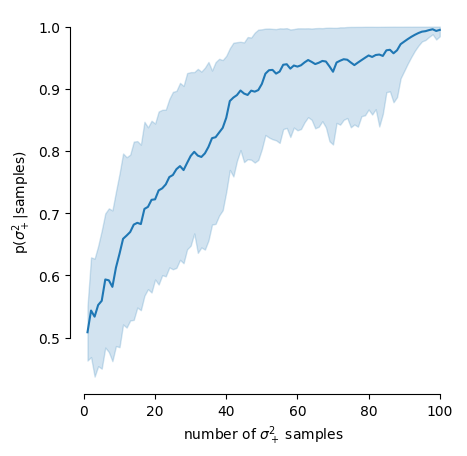

In [45]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# ax.plot(all_samples_n, all_p_sigma_plus)
sns.lineplot(data=dat, x="samples_n", y="sigma", ax=ax)
ax.set(xlabel="number of $\sigma^2_+$ samples", ylabel=r"p($\sigma^2_+$|samples)")
sns.despine(trim=True)

___

In [7]:
score, mean, variance, method_config, unit_id, mei = table.load_data(["score", "mean", "variance", "method_config", "unit_id", "mei"])
mei = [element for element in mei]
vei_type = np.array([dictionary["variance_optimization"] for dictionary in method_config])

data_vei = pd.DataFrame.from_dict({"score": score, "mean": mean, "variance": variance, "vei_type": vei_type, "unit_id": unit_id, "mei": mei})

# Get MEI data
mhash = np.unique(table.fetch("method_hash"))
key = (table & "method_hash = '{}'".format(mhash[0])).proj().fetch(as_dict=True)
for k in key:
    k["method_hash"] = 'f36b2ca6ab7b71e91ad190192b7da9ea' # CEI, 0.8, OneValue
score, cei_mean, cei_variance, unit_id, mei = (MEI() & key).load_data(["score", "mean", "variance", "unit_id", "mei"])
mei = [element for element in mei]
data_cei = pd.DataFrame.from_dict({"score": score, "mean": cei_mean, "variance": cei_variance, "unit_id": unit_id, "mei": mei})
data_cei["vei_type"] = "CEI"

data = pd.concat([data_vei, data_cei])
data.sort_values(["unit_id"], ignore_index=True, inplace=True)

100% 492/492 [00:00<00:00, 5467.70it/s]
100% 246/246 [00:00<00:00, 5848.14it/s]


In [8]:
dat_cei = data.loc[data["vei_type"] == "CEI"].sort_values(["unit_id"], ignore_index=True).replace({"min": "VEI-", "max": "VEI+"})
dat_min = data.loc[data["vei_type"] == "min"].sort_values(["unit_id"], ignore_index=True).replace({"min": "VEI-", "max": "VEI+"})
dat_max = data.loc[data["vei_type"] == "max"].sort_values(["unit_id"], ignore_index=True).replace({"min": "VEI-", "max": "VEI+"})

/usr/local/lib/python3.9/dist-packages/pandas/core/array_algos/replace.py:86: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [9]:
dat_min["norm_mean - 1"] = dat_min["mean"]/dat_cei["mean"] - 1
dat_min["norm_var - 1"] = dat_min["variance"]/dat_cei["variance"] - 1

dat_max["norm_mean - 1"] = dat_max["mean"]/dat_cei["mean"] - 1
dat_max["norm_var - 1"] = dat_max["variance"]/dat_cei["variance"] - 1

dat_cei["abs_var_diff"] = dat_max["variance"] - dat_min["variance"]
dat_cei["norm_var_diff"] = dat_max["norm_var - 1"] - dat_min["norm_var - 1"]
neuron_ids = dat_cei.sort_values("norm_var_diff")["unit_id"].to_numpy()
neuron_ids_abs = dat_cei.sort_values("abs_var_diff")["unit_id"].to_numpy()

In [19]:
np.array(list(set(neuron_ids[-20:]) | set(neuron_ids_abs[-20:])))

array([128, 130, 134, 263, 264, 141, 271, 273,  21, 155, 160, 165, 166,
       168,  47,  50, 182,  54,  58, 191,  64,  65,  68,  83,  85,  87,
        88, 220, 223,  97,  98, 101, 231, 104, 106, 239, 117, 251, 124])

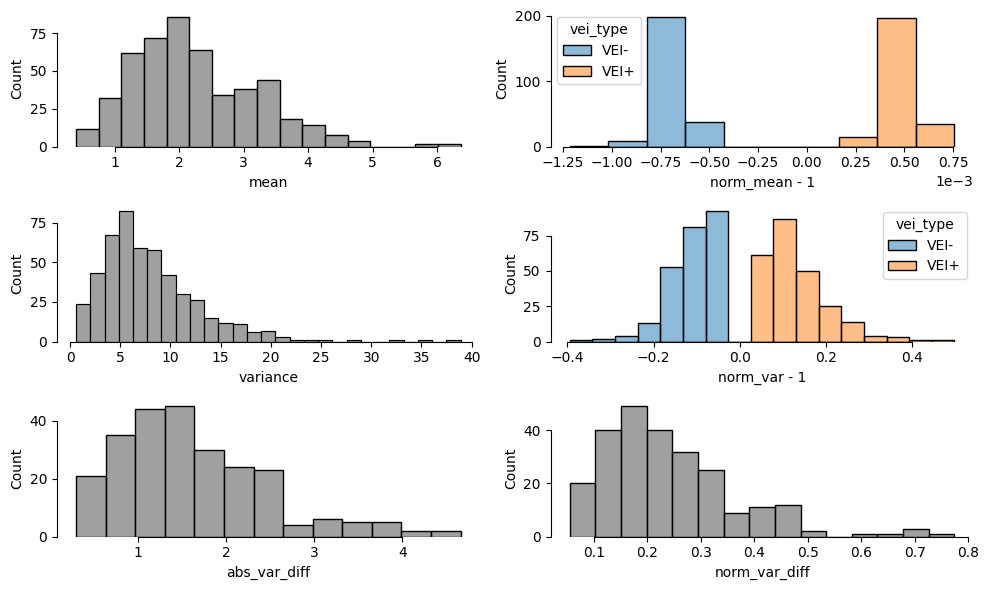

In [120]:
fig, axes = plt.subplots(3,2, figsize=(10, 6))
sns.histplot(data=pd.concat([dat_min, dat_max]), x="mean", ax=axes[0][0], color="gray")
sns.histplot(data=pd.concat([dat_min, dat_max]), x="norm_mean - 1", ax=axes[0][1], hue="vei_type")

sns.histplot(data=pd.concat([dat_min, dat_max]), x="variance", ax=axes[1][0], color="gray")
sns.histplot(data=pd.concat([dat_min, dat_max]), x="norm_var - 1", ax=axes[1][1], hue="vei_type")

sns.histplot(data=dat_cei, x="abs_var_diff", ax=axes[2][0], color="gray")
sns.histplot(data=dat_cei, x="norm_var_diff", ax=axes[2][1], color="gray")

# fig.delaxes(axes[2][1])
fig.tight_layout()
sns.despine(trim=True)
axes[0][1].ticklabel_format(axis="x", style='scientific', scilimits=(0,0))
# fig.savefig("orthogonal_veis_variance_analysis" + ".png", bbox_inches="tight", transparent=False)

#### Check min and max variances

In [17]:
print(((dat_cei["variance"] - dat_min["variance"])>0).all())
print(((dat_cei["variance"] - dat_max["variance"])<0).all())

True
True


#### Check mean values

In [25]:
x_min = dat_min["mean"]/dat_cei["mean"] - 1
x_max = dat_max["mean"]/dat_cei["mean"] - 1

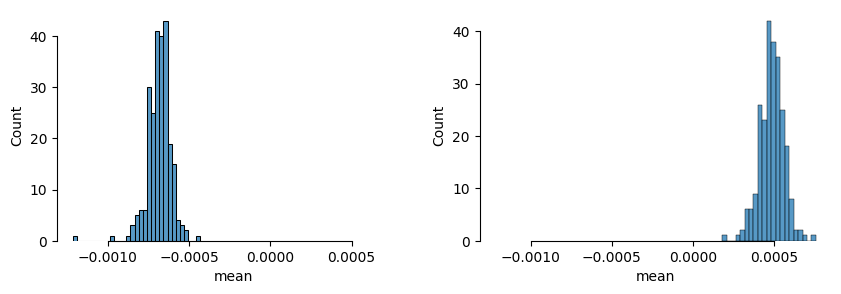

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharex=True)
sns.histplot(x_min, ax=axes[0])
sns.histplot(x_max, ax=axes[1])
sns.despine(trim=True)

#### Check angles

In [31]:
def angle(u, v):
    u = u.reshape(-1)
    v = v.reshape(-1)

    nominator = (u*v).sum()
    denominator = np.linalg.norm(u)*np.linalg.norm(v)
    return np.degrees(np.arccos(nominator/denominator))

In [45]:
angles_max, angles_min = [], []
for unit_id in np.unique(data["unit_id"]):
    cei = dat_cei.loc[(dat_cei["unit_id"] == unit_id)]["mei"].item()
    vei_max = dat_max.loc[(dat_max["unit_id"] == unit_id)]["mei"].item()
    vei_min = dat_min.loc[(dat_min["unit_id"] == unit_id)]["mei"].item()
    angles_max.append(angle(cei, vei_max-cei).round(1))
    angles_min.append(angle(cei, vei_min-cei).round(1))

In [46]:
print((np.array(angles_max) == 90.0).all())
print((np.array(angles_min) == 90.0).all())

True
True


#### Plot

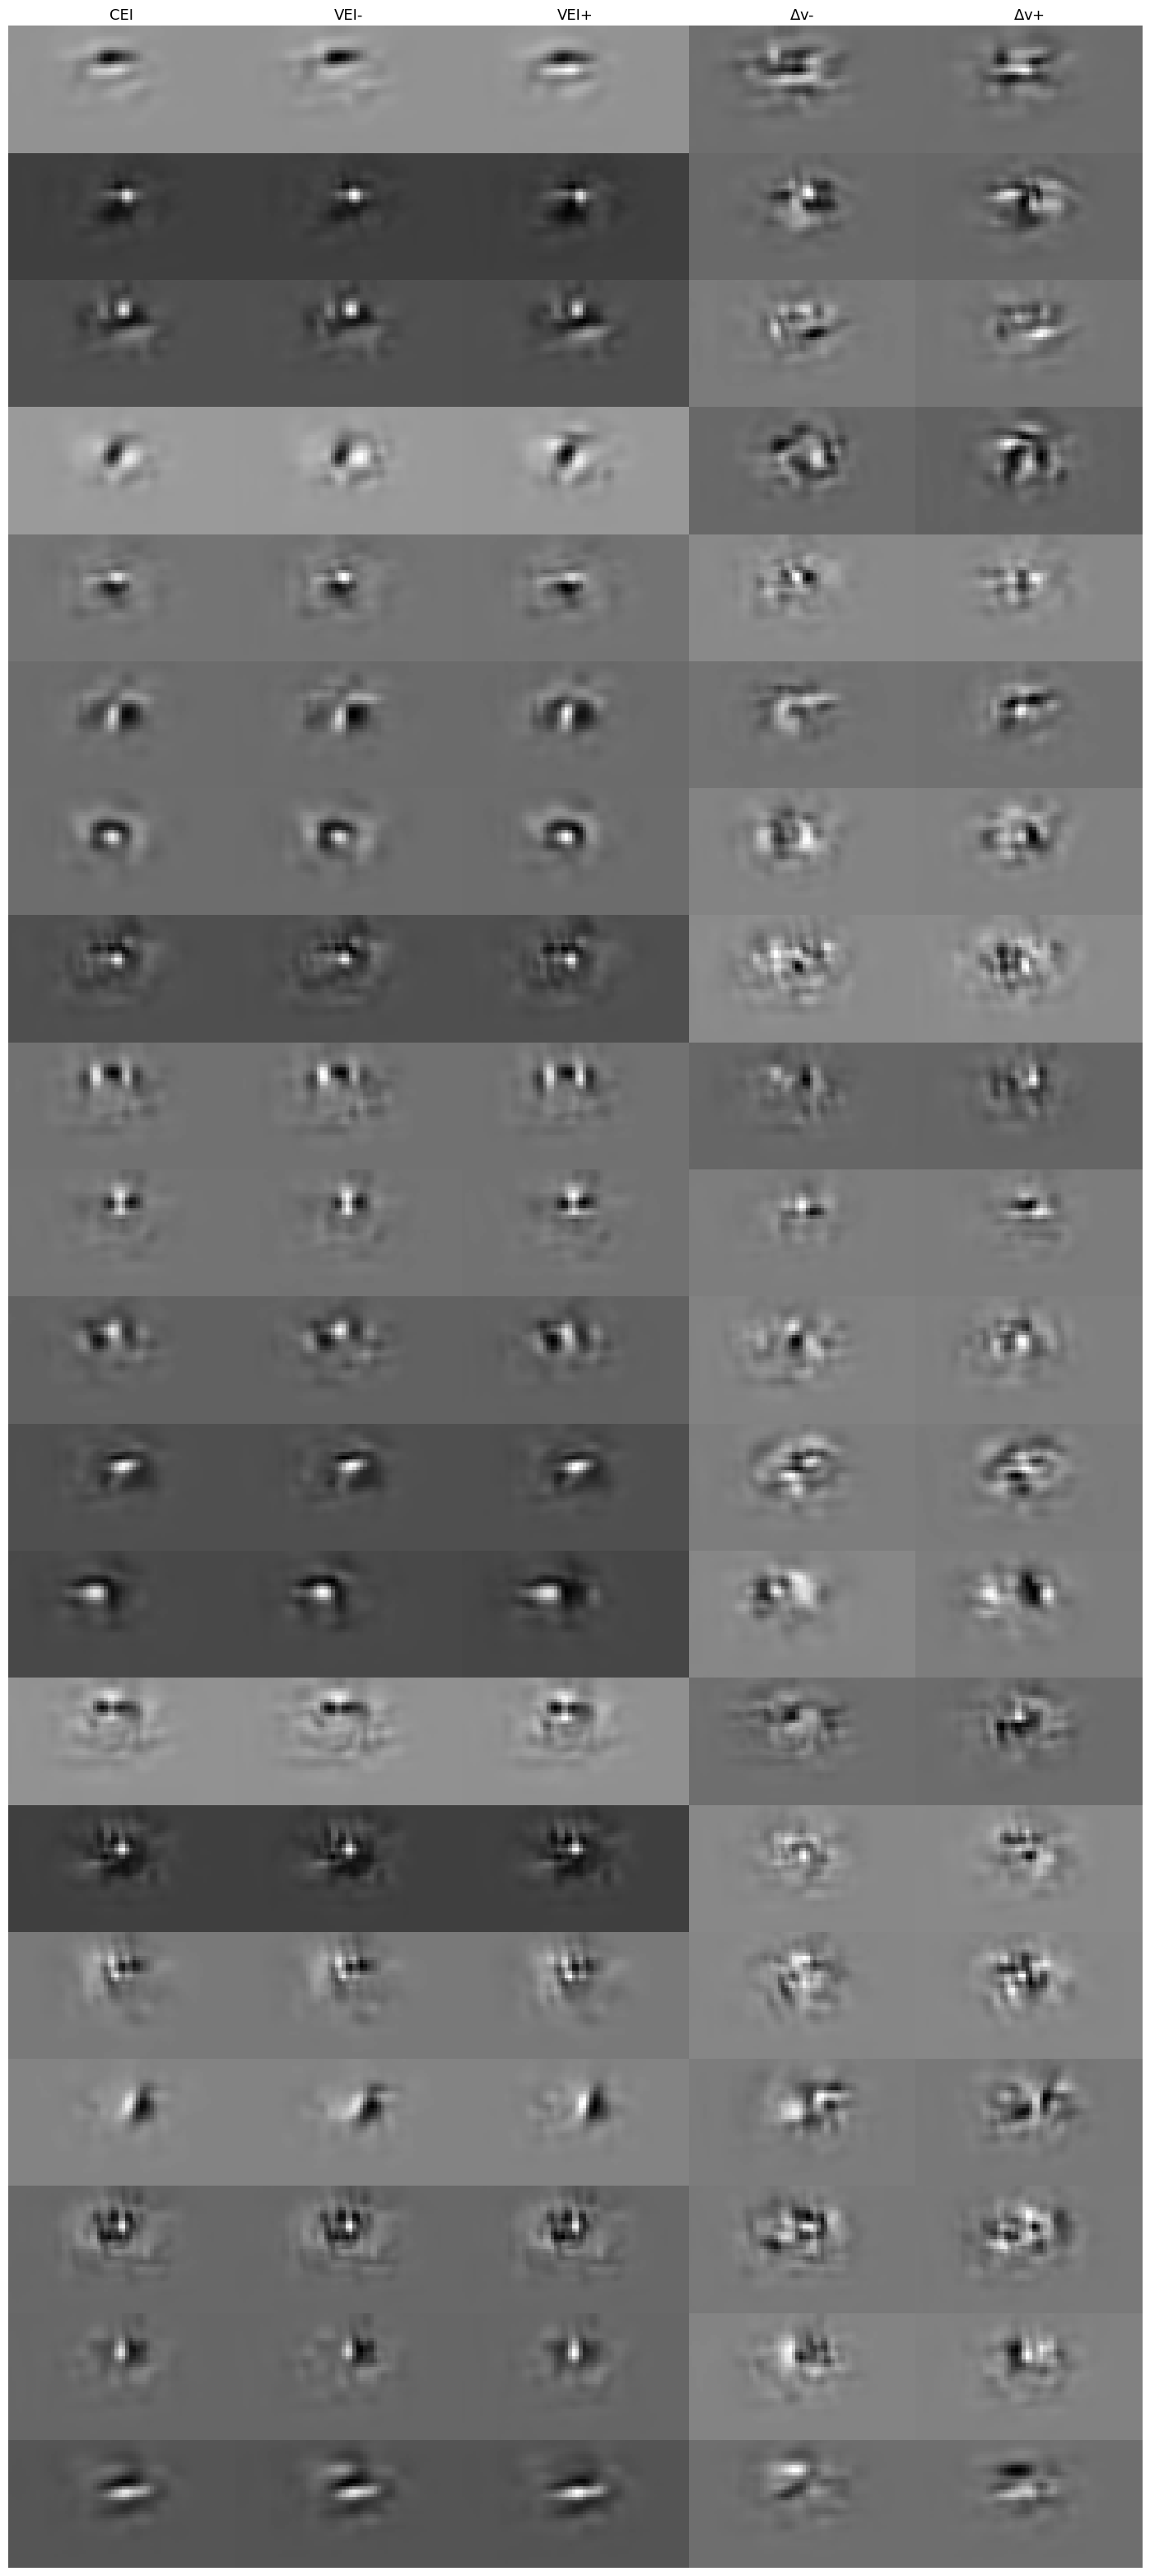

In [69]:
unit_ids = neuron_ids[-20:]
ratio = 64/36

fig, axes = plt.subplots(len(unit_ids), 5, figsize=(2*ratio*5, 2*len(unit_ids)+.3), dpi=100)
fontsize = 13

for i in range(len(unit_ids)):
    dat = data.loc[data["unit_id"] == unit_ids[i]]
    
    # CEI/VEI
    cei = dat.loc[dat["vei_type"] == "CEI"]["mei"].item().squeeze()
    vei_min = dat.loc[dat["vei_type"] == "min"]["mei"].item().squeeze()
    vei_max = dat.loc[dat["vei_type"] == "max"]["mei"].item().squeeze()
    vmax = np.concatenate([cei, vei_min, vei_max]).max()
    vmin = np.concatenate([cei, vei_min, vei_max]).min()

    axes[i, 0].imshow(cei, cmap="gray", vmin=vmin, vmax=vmax) 
    axes[i, 1].imshow(vei_min, cmap="gray", vmin=vmin, vmax=vmax) 
    axes[i, 2].imshow(vei_max, cmap="gray", vmin=vmin, vmax=vmax)

    # Delta
    delta_min = dat.loc[dat["vei_type"] == "min"]["mei"].item().squeeze() - cei
    delta_max = dat.loc[dat["vei_type"] == "max"]["mei"].item().squeeze() - cei
    vmax = np.concatenate([delta_min, delta_max]).max()
    vmin = np.concatenate([delta_min, delta_max]).min()
    
    axes[i, 3].imshow(delta_min, cmap="gray", vmin=vmin, vmax=vmax)    
    axes[i, 4].imshow(delta_max, cmap="gray", vmin=vmin, vmax=vmax)
    
    for j in range(5):
        axes[i, j].axis("off")

    if i == 0:
        axes[i, 0].set_title("CEI", fontsize=fontsize)
        axes[i, 1].set_title("VEI-", fontsize=fontsize)
        axes[i, 2].set_title("VEI+", fontsize=fontsize)
        axes[i, 3].set_title(r"$\Delta$v-", fontsize=fontsize)
        axes[i, 4].set_title(r"$\Delta$v+", fontsize=fontsize)
        
fig.subplots_adjust(wspace=0, hspace=-.1)
# fig.savefig("orthogonal_veis" + ".png", bbox_inches="tight", transparent=False)

## Post-optimization of different L1 experiment

#### Few neurons, fine grained L1

In [3]:
experiment_name = "Post-optimization of CEIs (0.8) created with different L1 weights, UNCORRUPTED Jiakun"
table = MEI() & (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'")
score, mean, variance, method_config, unit_id, mei = table.load_data(["score", "mean", "variance", "method_config", "unit_id", "mei"])
mei = [element for element in mei]
l1 = np.array([dictionary["initial"]["kwargs"]["l1"] for dictionary in method_config])

data_cei = pd.DataFrame.from_dict({"score": score, "mean": mean, "variance": variance, "l1": l1, "unit_id": unit_id, "mei": mei})

# Get MEI data
key = table.proj().fetch(as_dict=True)
for k in key:
    k["method_hash"] = '54f863f93364931f53ecdfe7c2bc5a03'
mei_mean, mei_variance, unit_id = (MEI() & key).fetch("mean", "variance", "unit_id")
data_mei = pd.DataFrame.from_dict({"mei_mean": mei_mean, "mei_variance": mei_variance, "unit_id": unit_id})

data = pd.merge(data_mei, data_cei, on="unit_id")
data.sort_values(["unit_id", "l1"], ignore_index=True, inplace=True)

100% 1000/1000 [00:00<00:00, 4623.91it/s]


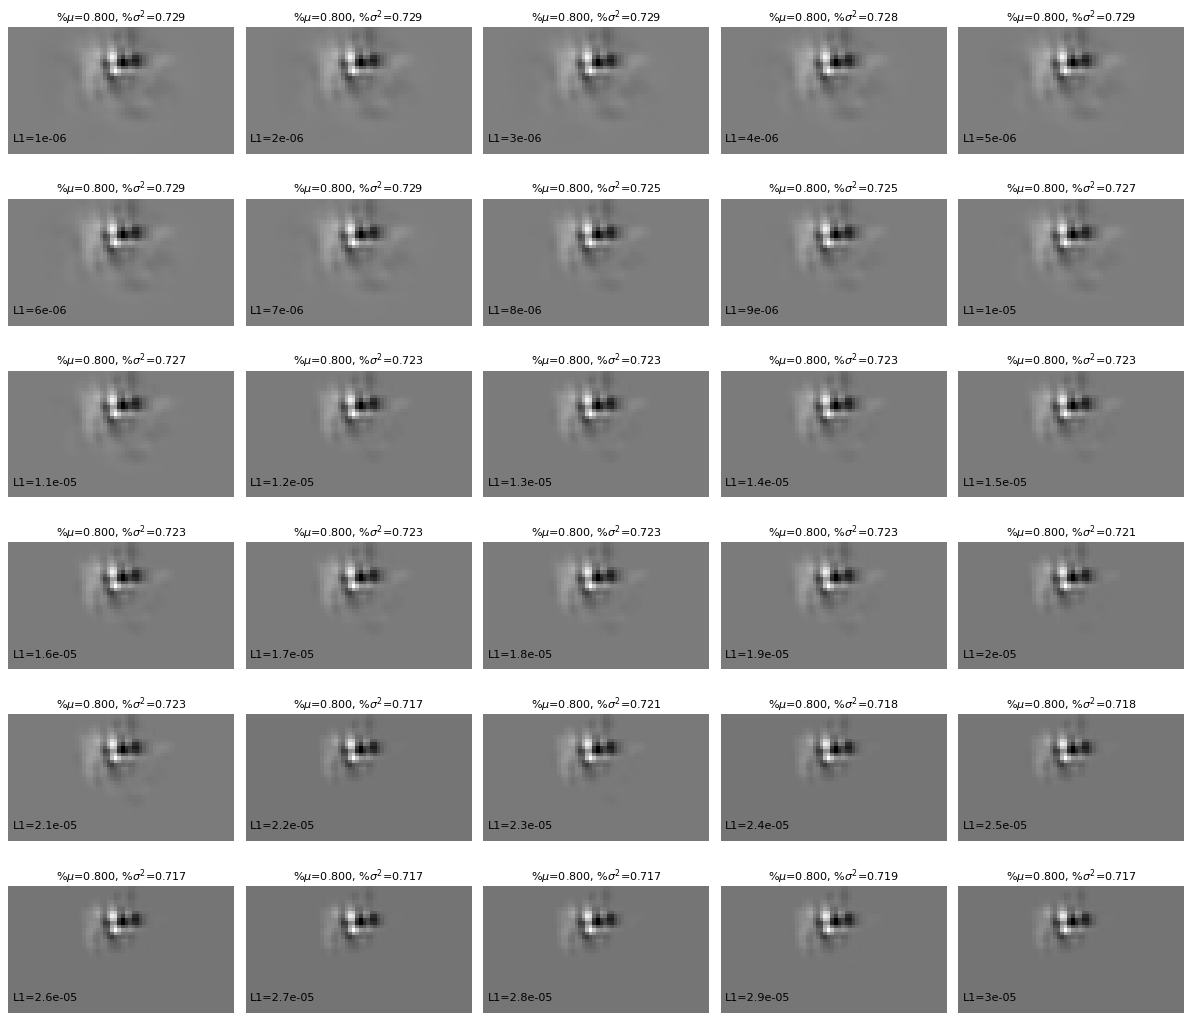

In [4]:
n_rows = 6
fig, axes = plt.subplots(n_rows, 5, figsize=(15, 2.2*n_rows), dpi=80)
fontsize = 10

dat = data.loc[(data["unit_id"] == 87) & (data["l1"] < 3.1e-5)].reset_index()

for i, ax in enumerate(axes.flatten()):
    ax.imshow(dat["mei"][i].squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(r"%$\mu$={:.3f}, %$\sigma^2$={:.3f}".format(dat["mean"][i]/dat["mei_mean"][i], dat["variance"][i]/dat["mei_variance"][i]), fontsize=fontsize)
    ax.text(0.02, .1, "L1=" + str(dat["l1"][i]), fontsize=fontsize, transform=ax.transAxes)
fig.tight_layout()
# fig.savefig("Post-optimization of CEIs (0.8) created with different L1 weights, CEI examples" + ".png", bbox_inches="tight", transparent=False)

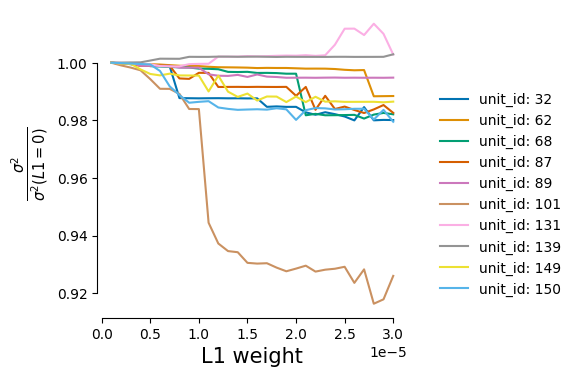

In [5]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
fontsize = 15
unit_ids = np.unique(data["unit_id"])

from matplotlib.colors import ListedColormap
my_cmap = sns.color_palette("colorblind").as_hex()


for i, unit_id in enumerate(unit_ids):
    dat = data.loc[(data["unit_id"] == unit_id) & (data["l1"] < 3.1e-5)].reset_index()
    ax.plot(dat["l1"], dat["variance"]/dat["variance"][0], label=f"unit_id: {unit_id}", color=my_cmap[i])

plt.xlabel('L1 weight', fontsize=fontsize)
plt.ylabel(r"$\frac{\sigma^2}{\sigma^2(L1=0)}$", fontsize=fontsize)

ax.legend(frameon=False, bbox_to_anchor=(1.3, 0.4), loc="center")
ax.ticklabel_format(axis="x", style='scientific', scilimits=(0,0))
sns.despine(trim=True)
# fig.savefig("Post-optimization of CEIs (0.8) created with different L1 weights, L1 vs variance" + ".png", bbox_inches="tight", transparent=False)

#### Many neurons

In [3]:
experiment_name = "Post-optimization of CEIs (0.8) created with different L1 weights, many neurons, UNCORRUPTED Jiakun"
table = MEI() & (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'")
score, mean, variance, method_config, method_hash, unit_id = table.load_data(["score", "mean", "variance", "method_config", "method_hash", "unit_id"])
l1 = np.array([dictionary["initial"]["kwargs"]["l1"] for dictionary in method_config])

data_cei = pd.DataFrame.from_dict({"score": score, "mean": mean, "variance": variance, "method_hash":method_hash, "l1": l1, "unit_id": unit_id})

# Get MEI data
key = table.proj().fetch(as_dict=True)
for k in key:
    k["method_hash"] = '54f863f93364931f53ecdfe7c2bc5a03'
mei_mean, mei_variance, unit_id = (MEI() & key).fetch("mean", "variance", "unit_id")
data_mei = pd.DataFrame.from_dict({"mei_mean": mei_mean, "mei_variance": mei_variance, "unit_id": unit_id})

data = pd.merge(data_mei, data_cei, on="unit_id")
data.sort_values(["unit_id", "l1"], ignore_index=True, inplace=True)

In [ ]:
# Only necessary for model performance per neuron

model_table  = TrainedModel & (TrainedEnsembleModel.Member & table)
seeds = model_table.fetch("seed")
unit_ids = np.sort(data.unit_id.unique())
model_data = pd.DataFrame.from_dict({"unit_id": unit_ids})

for i, seed in enumerate(seeds):
    dataloaders, model = (model_table & f"seed = {seed}").load_model()
    model.to(device)
    
    idx = []
    for unit_id in unit_ids:
        idx.append(np.where(dataloaders["train"]['27940-2-13-0'].dataset.neurons.unit_ids == unit_id)[0].item())
        
    loss = get_loss(model, dataloaders["test"], model.loss_fn, device=device, per_neuron=True, avg=True,)[idx]
    correlation = get_correlations(model, dataloaders["test"], device=device, )[idx]
    
    model_data = pd.merge(model_data, pd.DataFrame.from_dict({f"loss{i+1}": loss, f"corr{i+1}": correlation, "unit_id": unit_ids}), on="unit_id")
    
model_data["loss_mean"] = model_data[['loss1', 'loss2', 'loss3', 'loss4', 'loss5']].mean(axis=1)
model_data["corr_mean"] = model_data[['corr1', 'corr2', 'corr3', 'corr4', 'corr5']].mean(axis=1)

data = pd.merge(data, model_data, on="unit_id")
data.sort_values(["unit_id", "l1"], ignore_index=True, inplace=True)

In [4]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

slopes = []
unit_ids = np.sort(data.unit_id.unique())
for unit_id in unit_ids:
    dat = data.loc[data["unit_id"] == unit_id]
    slope = lin_reg.fit(dat[['l1']].values, dat[['variance']].values).coef_.item()
    slopes.append(slope)
data = pd.merge(data, pd.DataFrame.from_dict({"unit_id": unit_ids, "slope": slopes}))

neg_unit_ids = data.loc[data["l1"] == data["l1"][0]].sort_values("slope")["unit_id"][:5].to_numpy()
pos_unit_ids = data.loc[data["l1"] == data["l1"][0]].sort_values("slope")["unit_id"][-5:].to_numpy()

In [9]:
 data.loc[data["l1"] == data["l1"][0]].sort_values("slope")["unit_id"][125:130].to_numpy()

array([237, 272, 223,  89, 214])

In [6]:
pos_unit_ids

array([245, 172,  83, 196, 105])

In [9]:
dat = data.loc[data["l1"] == data["l1"][0]]
dat = dat.sort_values("slope")

method_hashes = data.loc[data["unit_id"] == 32].reset_index().iloc[[0, 4, 9, 14, 19, 24]]["method_hash"].to_numpy()

neg_table = (table & f"unit_id in {tuple(pos_unit_ids)}" & f"method_hash in {tuple(method_hashes)}") # change pos_unit_ids/neg_unit_ids

score, mean, variance, method_config, unit_id, mei = neg_table.load_data(["score", "mean", "variance", "method_config", "unit_id", "mei"])
l1 = np.array([dictionary["initial"]["kwargs"]["l1"] for dictionary in method_config])

neg_data = pd.DataFrame.from_dict({"score": score, "mean": mean, "variance": variance, "mei": [m for m in mei], "l1": l1, "unit_id": unit_id})

100% 30/30 [00:00<00:00, 3352.76it/s]


___

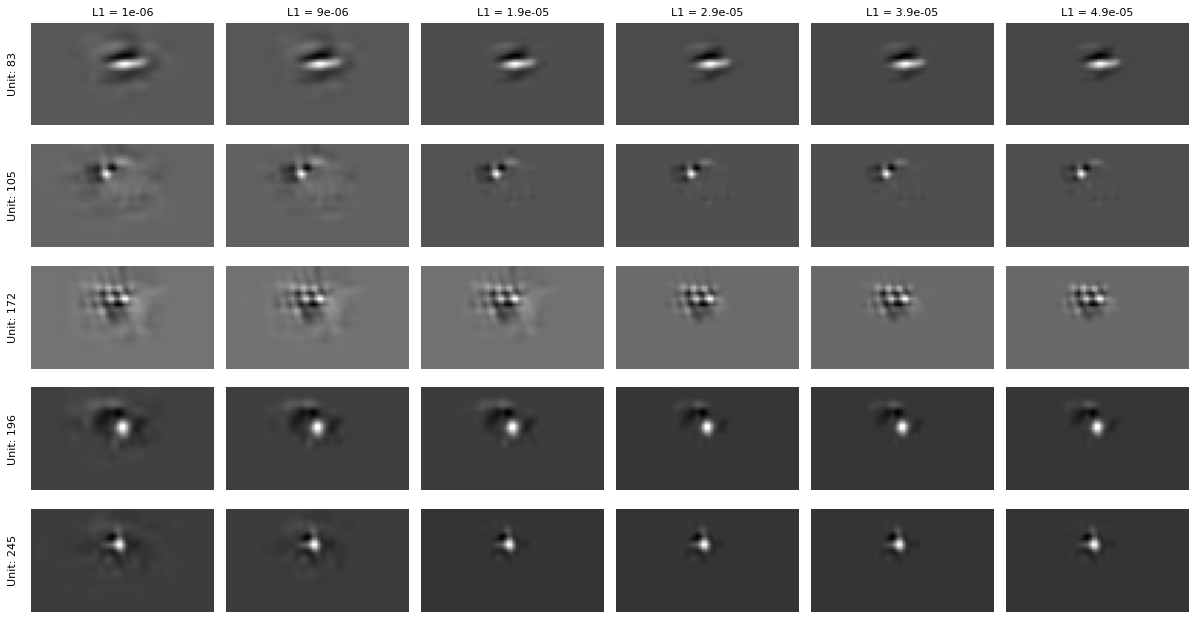

In [35]:
fig, axes = plt.subplots(5, 6, figsize=(15, 8), dpi=80)
fontsize = 10

for i, uid in enumerate(neg_data["unit_id"].unique()):
    dd = neg_data.loc[neg_data["unit_id"] == uid].sort_values("l1").reset_index()
    for j in range(len(dd)):
        axes[i, j].imshow(dd["mei"][j].squeeze(), cmap="gray") #, vmin=-1.7, vmax=1.7
        axes[i, j].axis("off")
        if i==0:
            axes[i, j].set_title(f"L1 = {dd['l1'][j]}", fontsize=fontsize)
        if j==0:
            axes[i,j].text(-.1, 0.5, f"Unit: {dd['unit_id'][i]}", transform=axes[i,j].transAxes, rotation = 90, fontsize=fontsize, horizontalalignment='center',     verticalalignment='center')
        # axes.text(0.02, .1, "L1=" + str(dat["l1"][i]), fontsize=fontsize, transform=ax.transAxes)
fig.tight_layout()
# fig.savefig("Negative slope neurons" + ".png", bbox_inches="tight", transparent=False)

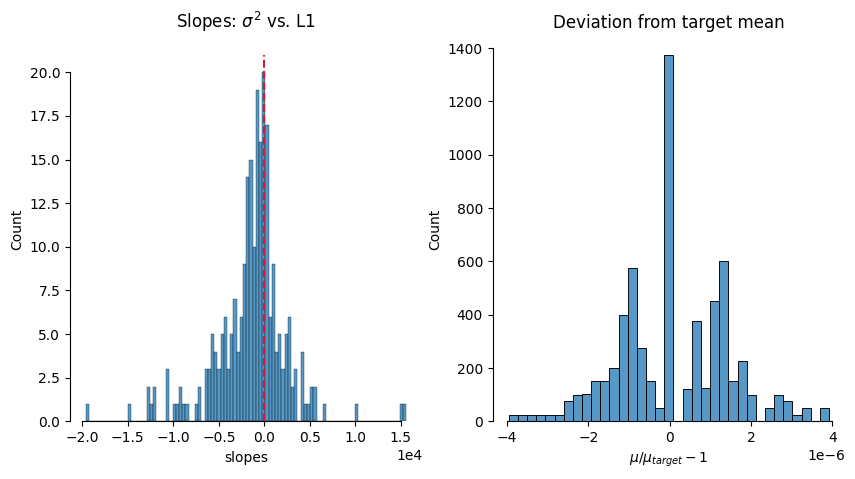

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = [ax]
dat = data.loc[data["l1"] == data["l1"][0]]

# Distribution of sopes
sns.histplot(dat["slope"], ax=ax[0][0], bins=100)
ax[0][0].set(xlabel="slopes", title=r"Slopes: $\sigma^2$ vs. L1")
ax[0][0].vlines(0, ax[0][0].get_ylim()[0], ax[0][0].get_ylim()[1], ls="--", color="crimson")
ax[0][0].ticklabel_format(axis="x", style='scientific', scilimits=(0,0))

# Slopes vs. correlation and loss
# sns.scatterplot(dat, x="slope", y="corr_mean", ax=ax[1][0])
# sns.scatterplot(dat, x="slope", y="loss_mean", ax=ax[1][1])

# ax[1][0].set(ylabel="correlation")
# ax[1][1].set(ylabel="loss")

# Deviation from target mean
x = data["mean"]/(0.8*data["mei_mean"]) -1
sns.histplot(x, ax=ax[0][1])
ax[0][1].ticklabel_format(axis="x", style='scientific', scilimits=(0,0))
ax[0][1].set(xlabel=r"$\mu/\mu_{target} - 1$", title="Deviation from target mean")

sns.despine(trim=True)
# fig.savefig("Post-optimization of CEIs (0.8) created with different L1 weights, many neurons" + ".png", bbox_inches="tight", transparent=False)

___

## VEI Experiment

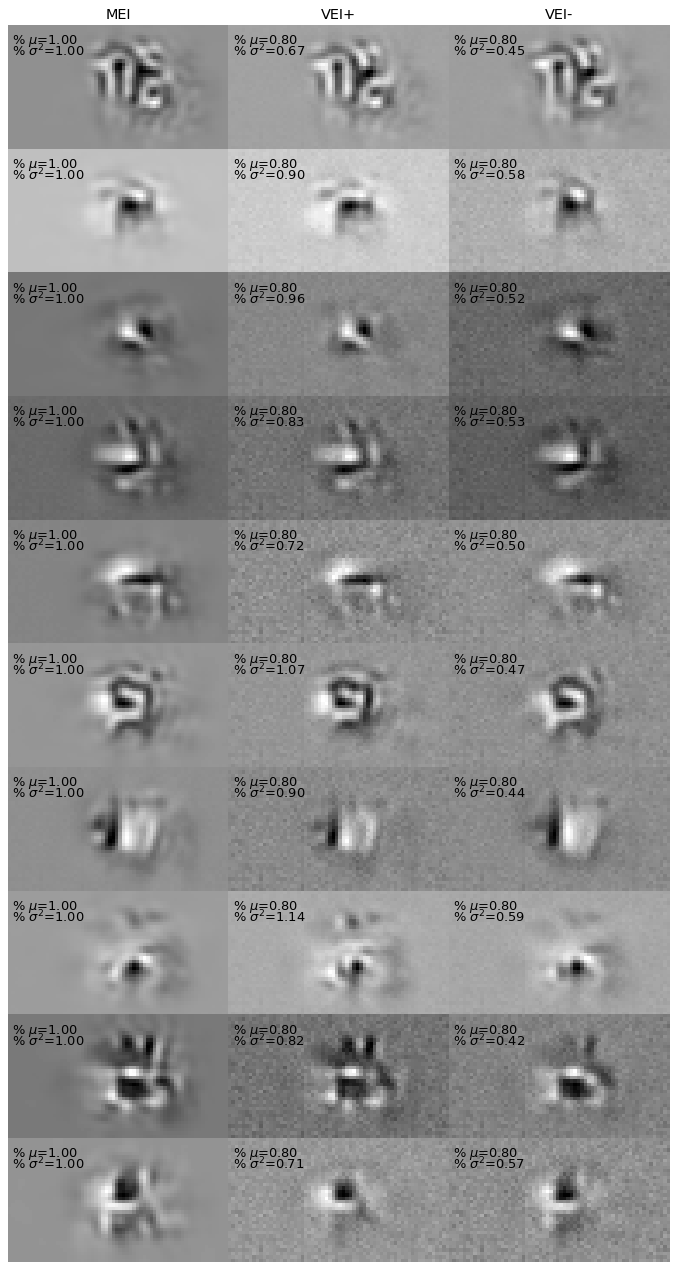

In [5]:
experiment_name = "Mouse V1, mu=0.8, gamma models" #"Zhiwei0, alternative ensemble, OneValue init"
model_types = ["MEI", "VEI+", "VEI-"]


if "Monkey" in experiment_name:
    ratio = 1
    mei_table = MEIMonkey
    experiment_table = MEIExperimentsMonkey
    dpi=130
else:
    ratio = 64/36
    mei_table = MEI
    experiment_table = MEIExperimentsMouse
    dpi = 80
    
data_table = mei_table() * MEIMethod & (experiment_table.Restrictions() & f"experiment_name = '{experiment_name}'")
finished_unit_ids = np.unique(data_table.fetch("unit_id"))
ensemble_comment = np.unique((data_table * TrainedEnsembleModel).fetch("ensemble_comment")).item()

fig, axes = plt.subplots(len(finished_unit_ids), len(model_types), figsize=(2*ratio*len(model_types), 2*len(finished_unit_ids)+.3), dpi=dpi)
fontsize = 13

for i in range(len(finished_unit_ids)):
    for j, mei_type in enumerate(model_types):
        method_restr = f"method_comment like '%{mei_type}%'"
        table = (data_table & f"unit_id = {finished_unit_ids[i]}" & method_restr)
        mei_path, mean, variance = table.fetch1("mei", "mean", "variance")
        if mei_type == "MEI":
            mei_mean = mean
            mei_variance = variance
        mei = load(mei_path)
        os.remove(mei_path)
        axes[i, j].imshow(mei.squeeze(), cmap="gray")
        axes[i, j].axis("off")
        axes[i, j].text(0.02,
                        .85,
                        r"% $\mu$={:.2f}".format(mean/mei_mean),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        axes[i, j].text(0.02,
                        .75,
                        r"% $\sigma^2$={:.2f}".format(variance/mei_variance),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        if i == 0:
            axes[i, j].set_title(mei_type, fontsize=fontsize)
fig.subplots_adjust(wspace=0, hspace=-.1)
# fig.savefig(experiment_name + ".png", bbox_inches="tight", transparent=False)

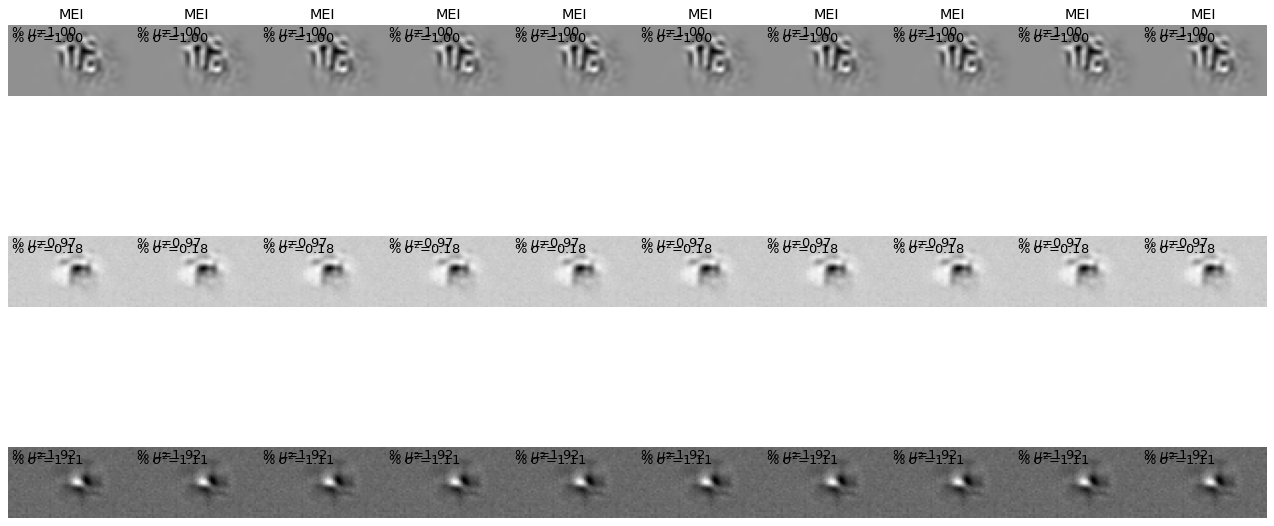

In [6]:
experiment_name = "Mouse V1, mu=0.8, gamma models" #"Zhiwei0, alternative ensemble, OneValue init"
model_types = ["MEI", "VEI+", "VEI-"]


if "Monkey" in experiment_name:
    ratio = 1
    mei_table = MEIMonkey
    experiment_table = MEIExperimentsMonkey
    dpi=130
else:
    ratio = 64/36
    mei_table = MEI
    experiment_table = MEIExperimentsMouse
    dpi = 80
    
data_table = mei_table() * MEIMethod & (experiment_table.Restrictions() & f"experiment_name = '{experiment_name}'")
finished_unit_ids = np.unique(data_table.fetch("unit_id"))
ensemble_comment = np.unique((data_table * TrainedEnsembleModel).fetch("ensemble_comment")).item()

fig, axes = plt.subplots(len(model_types), len(finished_unit_ids), figsize=(2*len(finished_unit_ids)+.3, 2*ratio*len(model_types)), dpi=dpi)
fontsize = 13

for j in range(len(finished_unit_ids)):
    for i, mei_type in enumerate(model_types):
        method_restr = f"method_comment like '%{mei_type}%'"
        table = (data_table & f"unit_id = {finished_unit_ids[i]}" & method_restr)
        mei_path, mean, variance = table.fetch1("mei", "mean", "variance")
        if mei_type == "MEI":
            mei_mean = mean
            mei_variance = variance
        mei = load(mei_path)
        os.remove(mei_path)
        axes[i, j].imshow(mei.squeeze(), cmap="gray")
        axes[i, j].axis("off")
        axes[i, j].text(0.02,
                        .85,
                        r"% $\mu$={:.2f}".format(mean/mei_mean),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        axes[i, j].text(0.02,
                        .75,
                        r"% $\sigma^2$={:.2f}".format(variance/mei_variance),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        if i == 0:
            axes[i, j].set_title(mei_type, fontsize=fontsize)
fig.subplots_adjust(wspace=0, hspace=-.1)
# fig.savefig(experiment_name + ".png", bbox_inches="tight", transparent=False)

##### Difference between VEIs

In [ ]:
data = np.empty((10, 3, 36, 64))*np.nan
for i in range(len(fig.axes)):
    x = np.ma.getdata(fig.axes[i].get_images()[0].get_array())
    data[i//3, i%3, :, :] = x

In [ ]:
fig2, axes = plt.subplots(data.shape[0], 4, figsize=(10, 15), dpi=100)
fontsize = 10
for i, x in enumerate(data):
    axes[i, 0].imshow(x[0], cmap="gray")
    axes[i, 1].imshow(x[1], cmap="gray")
    axes[i, 2].imshow(x[2], cmap="gray")
    axes[i, 3].imshow(x[1]-x[2], cmap="gray")
    axes[i, 0].axis("off")
    axes[i, 1].axis("off")
    axes[i, 2].axis("off")
    axes[i, 3].axis("off")
axes[0, 0].set_title("MEI", fontsize=fontsize)
axes[0, 1].set_title("VEI+", fontsize=fontsize)
axes[0, 2].set_title("VEI-", fontsize=fontsize)
axes[0, 3].set_title("DIFF(VEIs)", fontsize=fontsize)
# fig2.savefig("diff_of_veis" + ".png", bbox_inches="tight", transparent=False)

## Norm comparison

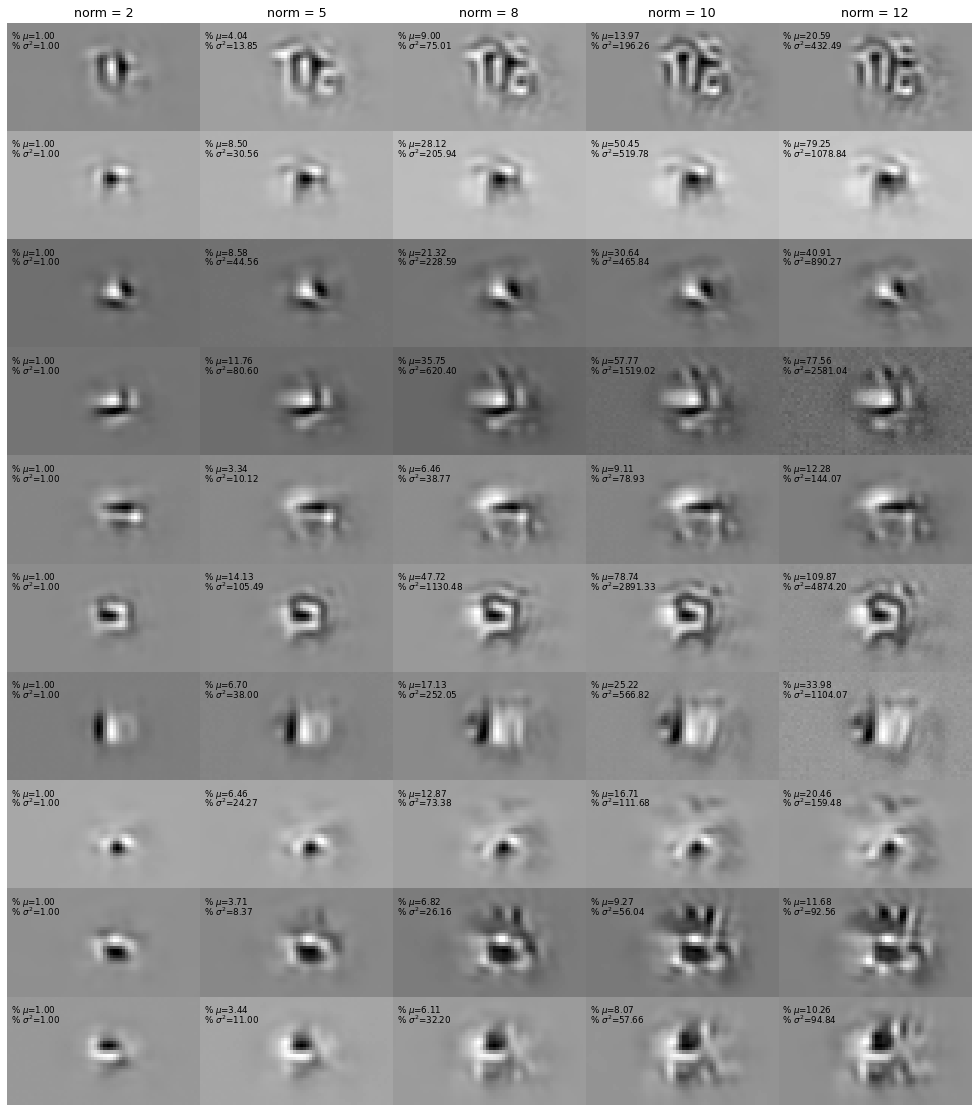

In [57]:
experiment_name = "Mouse V1, MEIs with different norm, gamma models"

data_table = mei_table() * MEIMethod & (experiment_table.Restrictions() & f"experiment_name = '{experiment_name}'")
finished_unit_ids = np.unique(data_table.fetch("unit_id"))
ensemble_comment = np.unique((data_table * TrainedEnsembleModel).fetch("ensemble_comment")).item()
methods = ['MEI, norm=2', 'MEI, norm=5', 'MEI, norm=8', 'MEI', 'MEI, norm=12']

fig, axes = plt.subplots(len(finished_unit_ids), 5, figsize=(2*ratio*5, 2*len(finished_unit_ids)+.3), dpi=70)
fontsize = 10

for i in range(len(finished_unit_ids)):
    for j, method in enumerate(methods):
        method_restr = f"method_comment = '{method}'"
        table = (data_table & f"unit_id = {finished_unit_ids[i]}" & method_restr)
        mei_path, mean, variance = table.fetch1("mei", "mean", "variance")
        norm = table.fetch1("method_config")["postprocessing"]["kwargs"]["norm"]
        
        if method == methods[0]:
            mei_mean = mean
            mei_variance = variance
        mei = load(mei_path)
        os.remove(mei_path)
        axes[i, j].imshow(mei.squeeze(), cmap="gray")
        axes[i, j].axis("off")
        axes[i, j].text(0.02,
                        .85,
                        r"% $\mu$={:.2f}".format(mean/mei_mean),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        axes[i, j].text(0.02,
                        .75,
                        r"% $\sigma^2$={:.2f}".format(variance/mei_variance),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        if i == 0:
            axes[i, j].set_title(f"norm = {norm}", fontsize=fontsize*1.3)
fig.subplots_adjust(wspace=0, hspace=-.1)
# fig.savefig(ensemble_comment + "_norm_comparison" + ".png", bbox_inches="tight", transparent=False)

___

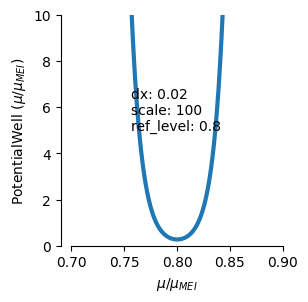

In [78]:
def potential_well(mean, dx=0.02, ref_level=0.8, scale=100):
    out = np.exp(-scale * (mean + dx - ref_level)) + np.exp(
        scale * (mean - dx - ref_level)
    )
    return out

fig, ax = plt.subplots()
x = np.linspace(.7, .9, 1000)
y = potential_well(x)
ax.plot(x, y, lw=3)
ax.set(xlabel=r"$\mu/\mu_{MEI}$", ylabel=r"PotentialWell ($\mu/\mu_{MEI})$")
ax.text(.3, .5, "dx: 0.02\nscale: 100\nref_level: 0.8", transform=ax.transAxes)
ax.set(ylim=(0, 10))
sns.despine(trim=True)
# fig.savefig("potential_well" + ".png", bbox_inches="tight", transparent=False)

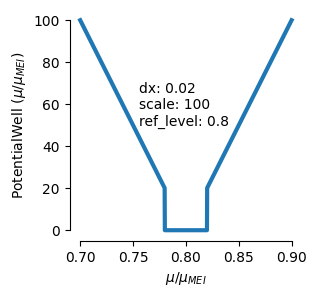

In [33]:
def linear_potential_well(mean, dx=0.02, ref_level=0.8, scale=1000):
    if ref_level - dx < mean < ref_level + dx:
        out = 0
    else:
        out = abs(mean - ref_level) * scale
    return out

fig, ax = plt.subplots()
x = np.linspace(.7, .9, 1000)
y = [linear_potential_well(x_) for x_ in x]
ax.plot(x, y, lw=3)
ax.set(xlabel=r"$\mu/\mu_{MEI}$", ylabel=r"PotentialWell ($\mu/\mu_{MEI})$")
ax.text(.3, .5, "dx: 0.02\nscale: 100\nref_level: 0.8", transform=ax.transAxes)
sns.despine(trim=True)
# fig.savefig("potential_well" + ".png", bbox_inches="tight", transparent=False)

In [59]:
y

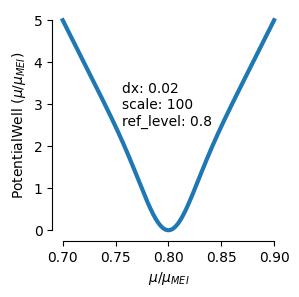

In [79]:
def linear_potential_well(x, dx=0.02, ref_level=0.8, scale=100):
    x = torch.from_numpy(x)
    
    out = scale*.5*(x - ref_level)*(torch.erf((x - ref_level)/np.sqrt(2)/dx))
    return out
        

fig, ax = plt.subplots()
x = np.linspace(.7, .9, 1000)
# x = np.linspace(-10, 10, 1000)

y = linear_potential_well(x)
ax.plot(x, y, lw=3)
ax.set(xlabel=r"$\mu/\mu_{MEI}$", ylabel=r"PotentialWell ($\mu/\mu_{MEI})$")
ax.text(.3, .5, "dx: 0.02\nscale: 100\nref_level: 0.8", transform=ax.transAxes)
sns.despine(trim=True)
# fig.savefig("potential_well" + ".png", bbox_inches="tight", transparent=False)